# Check alpha constraints for bispectrum

### Import all modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import interpn
import scipy.interpolate as interpolate


import pandas as pd

import scipy.stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

## Load data

In [2]:
Bk5=np.loadtxt("Bkavg_z0.50.DAT")
#Bk5=np.loadtxt("Bkavg_z0.73.DAT")

In [3]:
#remove all values corresponding to any k<=0.005
#Bk5=Bk5[Bk5[:,0]>0.006]
#Bk5.shape

(2600, 8)

## Interpolation

#### 1. scipy.interpolate.RegularGridInterpolator

In [4]:
k1=np.unique(Bk5[:,0])
k2=np.unique(Bk5[:,1])
k3=np.unique(Bk5[:,2])

kk1,kk2,kk3=np.meshgrid(k1,k2,k3)

tup_Bk5=[tuple(i) for i in Bk5[:,0:3]]

In [5]:
output = np.empty(shape=(len(k1),len(k2),len(k3)))

for i in range(len(k1)):
    for j in range(len(k2)):
        for k in range(len(k3)):
            kkk=[i for i in permutations((kk1[i,j,k],kk2[i,j,k],kk3[i,j,k]))]
            if any(set(kkk).intersection(set(tup_Bk5))):
                ind=tup_Bk5.index(list(set(kkk).intersection(set(tup_Bk5)))[0])
                #print((kk1[i,j,k],kk2[i,j,k],kk3[i,j,k]))
                #print(Bk5[ind,0:3])
                output[i,j][k]=Bk5[ind,5]
            else:
                output[i][j][k]=np.nan                
#print(output)

In [6]:
output1=output.flatten()
output1=pd.DataFrame(output1)
output1=output1.interpolate(method='linear', limit_direction='forward', axis=0)

In [7]:
output1=np.array(output1)
output1=np.reshape(output1,(len(k1),len(k2),len(k3)))

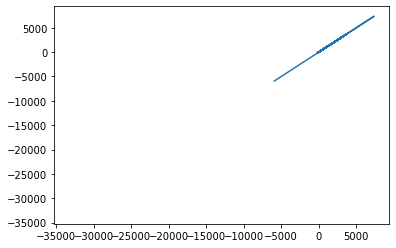

In [8]:
plt.plot(output.flatten(),output1.flatten())

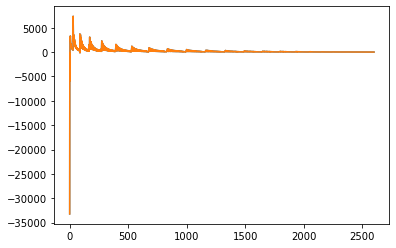

In [9]:
ff=RegularGridInterpolator((k1,k2,k3),output1,method="linear",bounds_error=False,fill_value=None)
#ff=LinearNDInterpolator((k1,k2,k3), output)
plt.plot(Bk5[:,5])
#plt.xlim(0,500)
plt.plot(ff((Bk5[:,0],Bk5[:,1],Bk5[:,2])))
#plt.xlim(500,550)

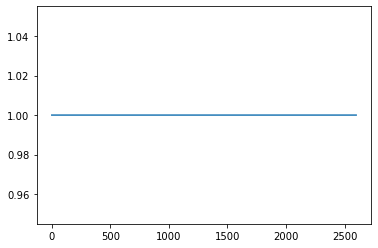

In [10]:
plt.plot(Bk5[:,5,]/ff((Bk5[:,0],Bk5[:,1],Bk5[:,2])))

#### 2. Random Forest

In [11]:
# model = RandomForestRegressor(max_depth=50, n_estimators=100, random_state=0)
# model.fit(Bk5[:,0:3], Bk5[:,5])
# test=model.predict(Bk5[:,0:3])

# mean_squared_error(Bk5[:,5],test,squared = False, multioutput = 'raw_values')

#### 3. Decision Tree with AdaBoost 

##### rmse is better but overall fitting isn't. 

In [12]:
# model= AdaBoostRegressor(DecisionTreeRegressor(max_depth=50), n_estimators=1000, random_state=0)
# model.fit(Bk5[:,0:3], Bk5[:,5])
# test=model.predict(Bk5[:,0:3])

# mean_squared_error(Bk5[:,5],test,squared = False, multioutput = 'raw_values')

#### 4. XgBoost

In [13]:
# model = xgb.XGBRegressor(n_estimators=1000, max_depth=50, eta=0.001, subsample=0.7, colsample_bytree=0.8)
# model.fit(Bk5[:,0:3],Bk5[:,5])
# test=model.predict(Bk5[:,0:3])

# mean_squared_error(Bk5[:,5],test,squared = False, multioutput = 'raw_values')

In [14]:
#plt.plot(test/Bk5[:,5])

## Chi-square test

In [11]:
def chisq(obs, exp, var):
    return np.sum((obs - exp)**2/var)

In [12]:
alp=np.linspace(0.9,1.1,10000)
def chisq_alp(Bk5,alp):
    error=[]
    obs=ff((Bk5[:,0],Bk5[:,1],Bk5[:,2]))
    var=Bk5[:,6]
    #obs=model.predict(Bk5[:,0:3])
    for i in alp:
        exp=ff((Bk5[:,0]*i,Bk5[:,1]*i,Bk5[:,2]*i))
        #exp=model.predict(Bk5[:,0:3]*i)
        # fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
        # plt.plot(exp)
        for j in range(len(exp)):
            if np.isnan(exp[j]):
                exp[j]=np.mean(np.concatenate((exp[j-1:j],exp[j+1:j+2])))
                #print(obs[j],exp[j])
        error.append(np.abs(chisq(obs, exp, var)))
        #ans=chisq(obs, exp,var)
        #print(i,ans)
        
    return error

In [13]:
error=chisq_alp(Bk5,alp)
least=np.min(error)
print(least)
ind=np.where((error<1+least+0.03) & (error>1+least-0.01))
print(ind)
left=ind[0][0]
right=ind[0][1]
print(alp[left],alp[right])
print(error[left],error[right])

8.72691457366162e-05
(array([4962, 5054]),)
0.9992499249924993 1.0010901090109012
1.019789111433445 1.001023075314664


Text(0, 0.5, 'chi-square')

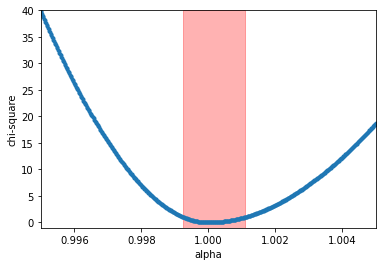

In [15]:
plt.plot(alp,error,".")
plt.axvspan(alp[left],alp[right], alpha=0.3, color='red')
#plt.plot(alp,np.ones(len(alp)))
plt.xlim(0.995,1.005)
plt.ylim(-1,40)
plt.xlabel("alpha")
plt.ylabel("chi-square")
#plt.legend()
#plt.savefig("chsq.png")

## Goodness-of-Fit check 

### 1. Interpolating to find 1sigma constraints

In [201]:
# from scipy import interpolate
# f = interpolate.interp1d(alp, error)

In [202]:
# alpn=np.linspace(0.98,1.02,10000)
# least=np.min(f(alpn))
# print(least)
# ind=np.where((f(alpn)<1+least+0.01) & (f(alpn)>1+least-0.001))
# print(ind)
# left=ind[0][0]
# right=ind[0][1]
# print(alpn[left],alpn[right])
# print(f(alpn)[left],f(alpn)[right])

### 2. Method 2

In [270]:
# goodness=np.array(error)#/(len(obs)-1)
# ind=np.where(goodness<=1)
# left=np.min(ind)
# right=np.max(ind)
# alp[left],alp[right]
# error[left],error[right]

### sigma_alpha vs kmax

In [226]:
# Bkmax245=Bk5[Bk5[:,2]<=0.245]
# Bkmax195=Bk5[Bk5[:,2]<=0.195]
# Bkmax145=Bk5[Bk5[:,2]<=0.145]
# Bkmax095=Bk5[Bk5[:,2]<=0.095]

# error1=chisq_alp(Bk5,alp)
# error2=chisq_alp(Bkmax245,alp)
# error3=chisq_alp(Bkmax195,alp)
# error4=chisq_alp(Bkmax145,alp)
# error5=chisq_alp(Bkmax095,alp)

### Plot chisq vs alpha for different kmax value

In [16]:
alp=np.linspace(0.9,1.1,20000)

all_errors=[]
all_kmax=[]
kmax_min=0.066
for kmax in reversed(k3):
    if kmax>kmax_min:
        bki = Bk5[Bk5[:,2]<=kmax]
        errori=chisq_alp(bki,alp)
        all_errors.append(errori)
        all_kmax.append(kmax)
        #print(kmax)
        #print(len(errori))

(-30.0, 500.0)

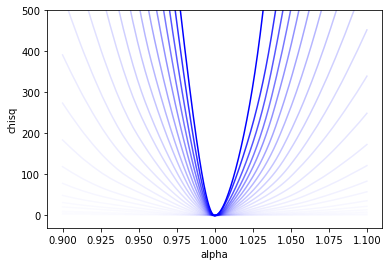

In [18]:
alpha = np.geomspace(1,0.01,len(all_errors)) # shaded parameter for plotting
for i,error in enumerate(all_errors):
    plt.plot(alp,error,alpha=alpha[i],color = 'b')
plt.ylabel("chisq")
plt.xlabel("alpha")
plt.ylim(-30,500)
#plt.savefig("all_chisq.png")

### 1sigma constriant vs kmax

Find 1sigma confidence interval (of chisq vs alpha plot) for different kmax. 

In [2]:
def find_1sigma(error,llim,rlim):
    least=np.min(error)
    #print(least)
    ind=np.where((error<1+least+rlim) & (error>1+least-llim))
    #print(ind)
    left=ind[0][0]
    right=ind[0][-1]
    # print(alp[left],alp[right])
    # print(1+least)
    # print(error[left],error[right])
    # print(alp[right]-alp[left])
    return alp[right]-alp[left]

In [22]:
sigma=[]
for i in all_errors:
    sigma.append(find_1sigma(i,0.01,0.01))

2.18186866266804e-05
(array([ 9925, 10108, 10109]),)
0.9992549627481375 1.0010950547527377
1.0000218186866268
1.0062952426929965 1.0099656428374173
0.0018400920046002245
1.9713588561451907e-05
(array([ 9914, 10115]),)
0.9991449572478625 1.0011550577528876
1.0000197135885613
0.9957707373032357 1.0063730639295398
0.0020101005050251475
1.3843408107205459e-05
(array([ 9901, 10137]),)
0.9990149507475374 1.0013750687534377
1.0000138434081072
1.002328945791071 0.9998839070289812
0.0023601180059003024
1.0317590854364416e-05
(array([ 9888, 10159]),)
0.9988849442472124 1.0015950797539879
1.0000103175908543
1.0036492588403734 1.001071463005833
0.0027101355067754573
8.096690448769134e-06
(array([ 9874, 10179, 10180]),)
0.9987449372468624 1.0018050902545128
1.0000080966904488
1.0036154757838858 1.0041953916521744
0.0030601530076503902
6.358838710594596e-06
(array([ 9858,  9859, 10202, 10203, 10204]),)
0.9985849292464624 1.002045102255113
1.0000063588387107
1.0073876641084287 1.0093607050277864
0.00

Text(0, 0.5, '1sigma_alpha')

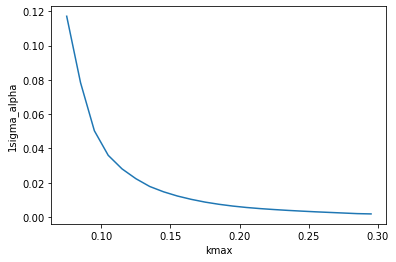

In [23]:
plt.plot(all_kmax,sigma)
plt.xlabel("kmax")
plt.ylabel("1sigma_alpha")
#plt.savefig("1sigma_alpha_vs_kmax.png")

In [3]:
Bk

NameError: name 'Bk' is not defined